In [1]:
import json

import os

import glob
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from analytical_solution import *

from plotly.subplots import make_subplots

In [2]:
path_data = os.path.join(os.getcwd(), 'data/simulations')

In [4]:
glob.glob(os.path.join(path_data) + '/*')

['/Users/javallejos/projects/Meshless-RBF-Solve-Burger-Equation/data/simulations/solution_MQ_Mi_25_Mb_24_nu_0.01.json',
 '/Users/javallejos/projects/Meshless-RBF-Solve-Burger-Equation/data/simulations/solution_MQ_Mi_80_Mb_52_nu_0.01.json',
 '/Users/javallejos/projects/Meshless-RBF-Solve-Burger-Equation/data/simulations/solution_TPS_Mi_80_Mb_52_nu_0.01_Hermite.json',
 '/Users/javallejos/projects/Meshless-RBF-Solve-Burger-Equation/data/simulations/solution_TPS_Mi_25_Mb_24_nu_0.01.json',
 '/Users/javallejos/projects/Meshless-RBF-Solve-Burger-Equation/data/simulations/solution_TPS_Mi_500_Mb_52_nu_0.001_Hermite.json',
 '/Users/javallejos/projects/Meshless-RBF-Solve-Burger-Equation/data/simulations/solution_TPS_Mi_25_Mb_24_nu_0.01_laguerre.json',
 '/Users/javallejos/projects/Meshless-RBF-Solve-Burger-Equation/data/simulations/solution_TPS_Mi_500_Mb_52_nu_0.02_Hermite.json',
 '/Users/javallejos/projects/Meshless-RBF-Solve-Burger-Equation/data/simulations/solution_TPS_Mi_80_Mb_52_nu_0.01_Arbit

In [24]:
with open(os.path.join(os.path.join(path_data), 'solution_TPS_Mi_28_Mb_16_nu_0.01_Laguerre.json'), 'r') as f:
#with open(os.path.join(os.path.join(path_data), 'solution_TPS_Mi_500_Mb_52_nu_0.02_Hermite.json'), 'r') as f:
    dataTPS500 = json.load(f)

In [25]:
nu = dataTPS500['nu']
rbf = dataTPS500['RBF']
Mi = np.array(dataTPS500['points']['Interior'])
Mb = np.array(dataTPS500['points']['boundary'])
uh_t = dataTPS500['solution']

In [26]:
def sol_uh(Mi, uh_t, t, j=0):
    X = Mi.copy()
    # data coordinates and values
    x = X[:,0]
    y = X[:,1]
    z = np.array(uh_t[t])[:, j]

    # target grid to interpolate to
    xi = yi = np.arange(0, 1, 1/(X.shape[0]))
    xi,yi = np.meshgrid(xi,yi)

    # set mask
    #mask = np.sqrt((xi - domain.c_x)**2 + (yi - domain.c_y)**2) < domain.radius

    # interpolate
    zi = griddata((x,y),z,(xi,yi), method='cubic')

    # mask out the field
    #zi[mask] = np.nan

    # plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    im = plt.contourf(xi,yi,zi)
    plt.plot(x,y,'k.')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    #plt.clim(0.48, 0.76)
    #plt.savefig('interpolated.png',dpi=100)
    plt.show()

In [27]:
@interact
def show_solution(t=(0, 10, 1)):
    return sol_uh(Mi, uh_t, str(t/10), j=0)

interactive(children=(IntSlider(value=5, description='t', max=10), Output()), _dom_classes=('widget-interact',…

In [28]:
def error_u(Mi, uht, nu):
    X = Mi.copy()
    U_dict = dict()
    U_obj = exact_solution(X, nu)
    U_sol = dict()
    for t in uht.keys():
        my_U = U_obj.u(float(t))
        U_sol[t] = my_U
        r = np.linalg.norm(my_U - np.array(uht[t]), axis=-1)
        U_dict[t] = r.reshape(-1,1).tolist() #U_obj.u(float(t)).tolist()

    return U_dict, U_sol

In [29]:
U_e, U_s = error_u(Mi, uh_t, nu)

In [54]:
@interact
def show_solution(t=(0, 10, 1)):
    return sol_uh(Mi, U_s, str(t/10), j=1)

interactive(children=(IntSlider(value=5, description='t', max=10), Output()), _dom_classes=('widget-interact',…

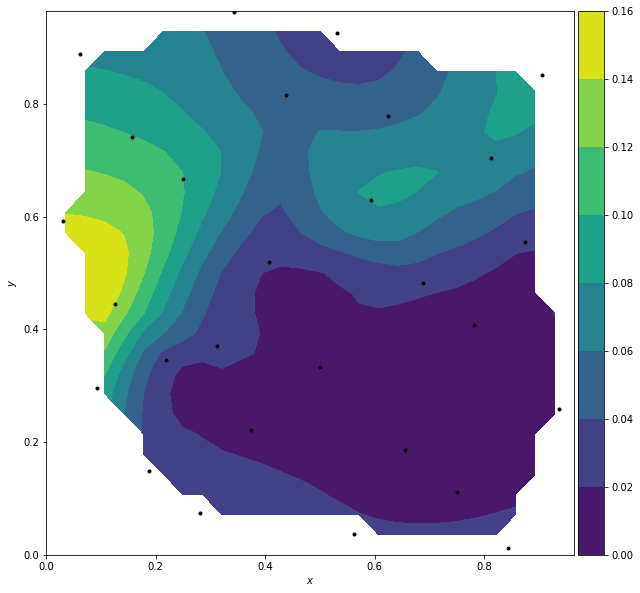

In [31]:
X = Mi.copy()
my_t = '0.5'

# data coordinates and values
x = X[:,0]
y = X[:,1]
z = np.array(U_e[my_t])[:, 0]

# target grid to interpolate to
xi = yi = np.arange(0, 1, 1/(X.shape[0]))
xi,yi = np.meshgrid(xi,yi)

# set mask
#mask = np.sqrt((xi - domain.c_x)**2 + (yi - domain.c_y)**2) < domain.radius

# interpolate
zi = griddata((x,y),z,(xi,yi), method='cubic')

# mask out the field
#zi[mask] = np.nan

# plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = plt.contourf(xi,yi,zi)
plt.plot(x,y,'k.')
plt.xlabel('$x$')
plt.ylabel('$y$')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
#plt.savefig('interpolated.png',dpi=100)
plt.show()


In [32]:

fig = go.Figure(data=[go.Surface(z=zi, x=xi, y=yi)])
fig.update_layout(title='Approximate solution o.f Burgers equation t={}'.format(my_t), autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True), colorscale="viridis")

fig.show()

In [44]:
class get_metrics(object):

    def __init__(self, Mi, nu, uh, *args, **kwargs):
        self.X = Mi.copy()
        self.x = self.X[:, 0]  # Plot error 2D
        self.y = self.X[:, 1]  # Plot error 2D
        self.xi, self.yi = np.meshgrid(np.arange(
            0, 1, 1/(self.X.shape[0])), np.arange(0, 1, 1/(self.X.shape[0])))  # Plot error 2D
        # self.mask = np.sqrt((self.xi - self.domain.c_x)**2 + (self.yi - self.domain.c_y)**2) < self.domain.radius #Plot error 2D
        self.nu = nu
        self.uh = uh
        self.errorl2_dict = dict()
        self.errorinf_dict = dict()
        self.solution_u = dict()
        self.error_dict = dict()

    def calculate_errors(self):
        U_obj = exact_solution(self.X, self.nu)
        for t in self.uh.keys():
            my_U = U_obj.u(float(t))
            self.solution_u[t] = my_U
            errorp2p = abs(my_U - np.array(self.uh[t]))/my_U * 1e-2
            error_l2 = np.linalg.norm(
                my_U - np.array(self.uh[t]), axis=0)/np.linalg.norm(my_U, axis=0)
            self.errorl2_dict[t] = error_l2.tolist()
            error_inf = np.linalg.norm(
                my_U - np.array(self.uh[t]), axis=0, ord=np.inf)/np.linalg.norm(my_U, axis=0, ord=np.inf)
            self.errorinf_dict[t] = error_inf.tolist()
            self.error_dict[t] = errorp2p.tolist()

    def plot_error_2D(self, t, j=0):
        z = np.array(self.error_dict[t])[:, j]
        # target grid to interpolate t

        # interpolate
        zi = griddata((self.x, self.y), z, (self.xi, self.yi), method='cubic')

        # mask out the field
        #zi[self.mask] = np.nan

        # plot
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        im = plt.contourf(self.xi, self.yi, zi)
        plt.plot(self.x, self.y, 'k.')
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        #plt.clim(0.48, 0.76)
        # plt.savefig('interpolated.png',dpi=100)
        plt.show()

    def plot_solutions_3D(self, t, j=0, t_label=None):

        fig = make_subplots(rows=1, cols=2, specs=[
            [
                {'type': 'surface'},
                {'type': 'surface'}
            ]
        ],
        )

        z_u = np.array(self.solution_u[t])[:, j]
        zi_u = griddata((self.x, self.y), z_u,
                        (self.xi, self.yi), method='cubic')
        fig_u = go.Surface(z=zi_u, x=self.xi, y=self.yi, showscale=False)
        # fig_u.update_traces(contours_z=dict(show=True, usecolormap=True,
        #                                 highlightcolor="limegreen", project_z=True), colorscale="viridis")

        z_uh = np.array(self.uh[t])[:, j]
        zi_uh = griddata((self.x, self.y), z_uh,
                         (self.xi, self.yi), method='cubic')
        fig_uh = go.Surface(z=zi_uh, x=self.xi, y=self.yi)
        # fig_uh.update_traces(contours_z=dict(show=True, usecolormap=True,
        #                                 highlightcolor="limegreen", project_z=True), colorscale="viridis")

        fig.add_trace(fig_u, row=1, col=1)
        fig.add_trace(fig_uh, row=1, col=2)

        fig.update_traces(contours_z=dict(show=True,
                                          usecolormap=True,
                                          highlightcolor="limegreen",
                                          project_z=True),
                          colorscale="viridis")

        fig.update_layout(title='Approximate solution of Burgers equation t={}'.format(t),
                          # autosize=False,
                          width=1000,
                          # height=800,
                          margin=dict(l=0, r=0, b=10, t=50)
                          )

        fig.show()

        fig2 = go.Figure(data=[fig_u, fig_uh])  

        fig2.show()


In [45]:
U = get_metrics(Mi, nu, uh_t)
U.calculate_errors()

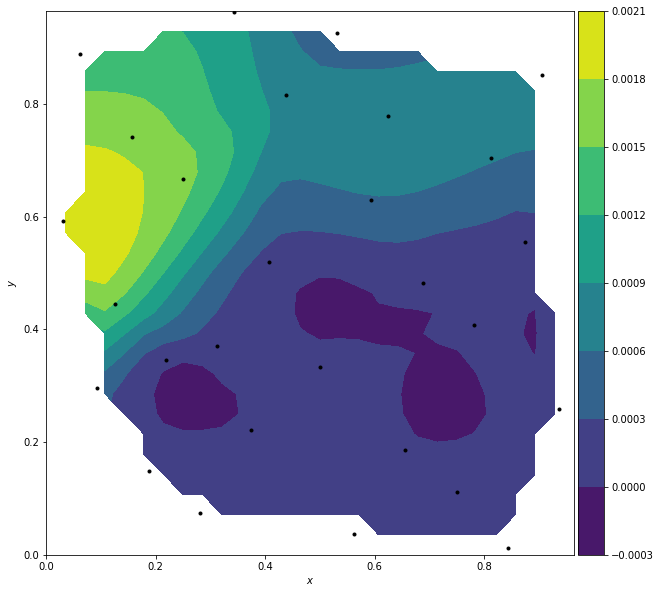

In [49]:
t='0.9'
U.plot_error_2D(t, j=1)
U.plot_solutions_3D(t)